<a href="https://colab.research.google.com/github/bala-codes/Document-Denoising-using-AutoEncoders/blob/master/Denoising%20Dirty%20Documents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
import glob
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import keras
from keras.preprocessing import image
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

from keras.models import Model
from keras import backend as k
from keras.optimizers import Adam
from keras.callbacks import *
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout, UpSampling2D

In [ ]:
plt.figure(figsize=(18,8))
image1 = cv2.imread('/content/train/101.png')
image2 = cv2.imread('/content/train_cleaned/101.png') 
final_frame = cv2.hconcat((image1, image2))
plt.imshow(final_frame, cmap='gray')
plt.show()

In [ ]:
train_images = glob.glob('/content/train/*.png')
clean_images = glob.glob('/content/train_cleaned/*.png')
test_images = glob.glob('/content/test/*.png')

In [ ]:
def load_image(path):
    image_list = np.zeros((len(path), 258, 540, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, color_mode='grayscale', target_size=(258, 540))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x
    
    return image_list


def train_val_split(x_train, y_train):
    rnd = np.random.RandomState(seed=42)
    perm = rnd.permutation(len(x_train))
    train_idx = perm[:int(0.8 * len(x_train))]
    val_idx = perm[int(0.8 * len(x_train)):]
    return x_train[train_idx], y_train[train_idx], x_train[val_idx], y_train[val_idx]

In [ ]:

X = load_image(train_images)
Y = load_image(clean_images)

x_train, y_train, x_val, y_val = train_val_split(X, Y)
print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

In [ ]:
def model_arch1():
  input_img = Input(shape=(258, 540, 1))
  h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
  h = MaxPooling2D((2, 2), padding='same')(h)

  # decoder
  h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
  h = UpSampling2D((2, 2))(h)
  output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)
  return Model(input_img, output_layer)

autoencoder = model_arch1()
autoencoder.compile(optimizer = Adam(lr=0.001), loss='mse')
#autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 258, 540, 1)       0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 258, 540, 64)      640       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 129, 270, 64)      0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 129, 270, 64)      36928     
_________________________________________________________________
up_sampling2d_29 (UpSampling (None, 258, 540, 64)      0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 258, 540, 1)       577       
Total params: 38,145
Trainable params: 38,145
Non-trainable params: 0
______________________________________________________

In [ ]:
%%time
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0001)

history = autoencoder.fit(x_train, y_train, epochs=300, batch_size=20, verbose = 2, shuffle=True, validation_data=(x_val, y_val), callbacks= [early_stopping, reduce_lr])

Train on 115 samples, validate on 29 samples
Epoch 1/300
 - 2s - loss: 0.0218 - val_loss: 0.0209
Epoch 2/300
 - 2s - loss: 0.0217 - val_loss: 0.0208
Epoch 3/300
 - 2s - loss: 0.0217 - val_loss: 0.0207
Epoch 4/300
 - 2s - loss: 0.0216 - val_loss: 0.0206
Epoch 5/300
 - 2s - loss: 0.0215 - val_loss: 0.0205
Epoch 6/300
 - 2s - loss: 0.0214 - val_loss: 0.0205
Epoch 7/300
 - 2s - loss: 0.0213 - val_loss: 0.0204
Epoch 8/300
 - 2s - loss: 0.0213 - val_loss: 0.0204
Epoch 9/300
 - 2s - loss: 0.0213 - val_loss: 0.0203
Epoch 10/300
 - 2s - loss: 0.0211 - val_loss: 0.0202
Epoch 11/300
 - 2s - loss: 0.0210 - val_loss: 0.0201
Epoch 12/300
 - 2s - loss: 0.0210 - val_loss: 0.0200
Epoch 13/300
 - 2s - loss: 0.0209 - val_loss: 0.0200
Epoch 14/300
 - 2s - loss: 0.0208 - val_loss: 0.0199
Epoch 15/300
 - 2s - loss: 0.0207 - val_loss: 0.0198
Epoch 16/300
 - 2s - loss: 0.0206 - val_loss: 0.0197
Epoch 17/300
 - 2s - loss: 0.0206 - val_loss: 0.0196
Epoch 18/300
 - 2s - loss: 0.0205 - val_loss: 0.0196
Epoch 19/3

In [ ]:
autoencoder.save("/content/drive/My Drive/Machine Learning Projects/DENOISING NOISY DOCUMENT/DDD1.h5")

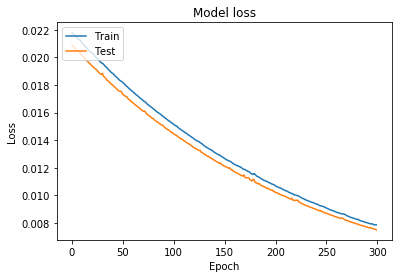

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/My Drive/Machine Learning Projects/DENOISING NOISY DOCUMENT/DDD1.h5')

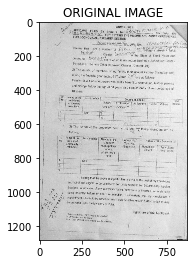

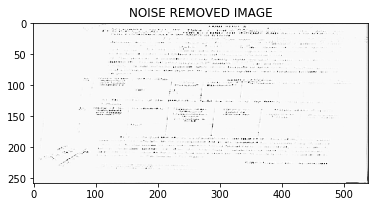


###################################################



In [ ]:
def load_single_image(path):
    image_list = np.zeros((258, 540, 1))
    img = image.load_img(path, color_mode='grayscale', target_size=(258, 540))
    x = image.img_to_array(img).astype('float32')
    x = x / 255.0
    image_list = x
    
    return image_list

def single_image_prediction(path):
  original = cv2.imread(path,0)
  plt.imshow(original, cmap='gray')
  plt.title("ORIGINAL IMAGE")
  plt.show()

  finalone = load_single_image(path)
  finalone = np.expand_dims(finalone, axis = 0)
  outme = model.predict(finalone)
  outme = outme.reshape(258,540,1)
  outme = outme * 255.0
  outme = outme.reshape(258, 540)
  plt.imshow(outme, cmap='gray')
  plt.title("NOISE REMOVED IMAGE")
  plt.show()
  print()
  print("###################################################")
  print()

single_image_prediction('/content/nnn.jpg')

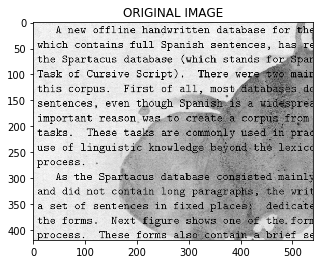

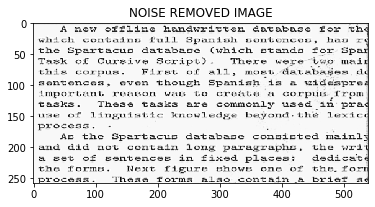


###################################################



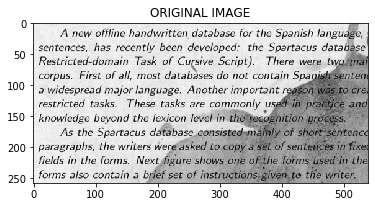

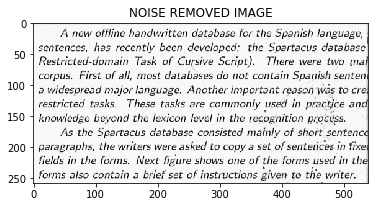


###################################################



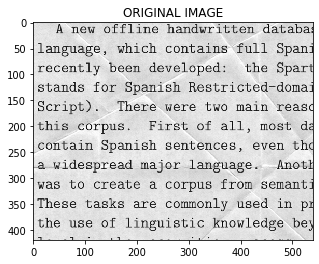

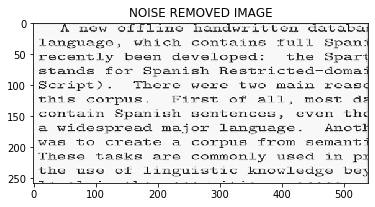


###################################################



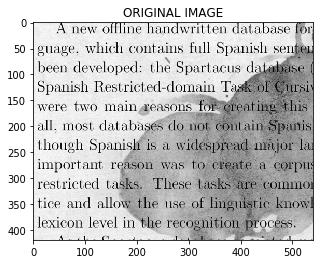

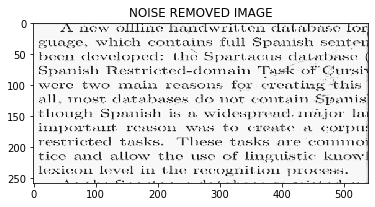


###################################################



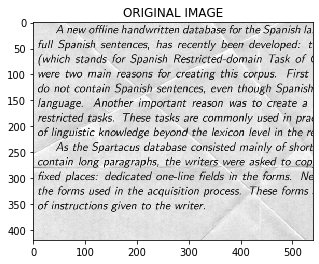

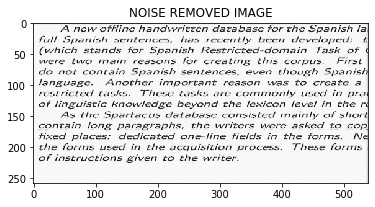


###################################################



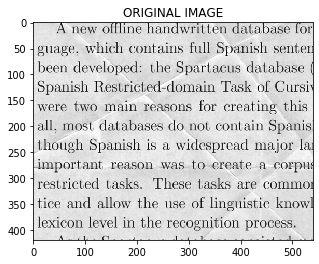

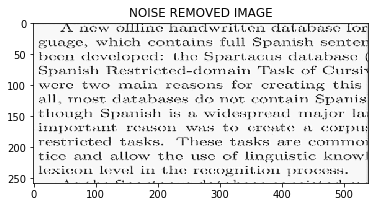


###################################################



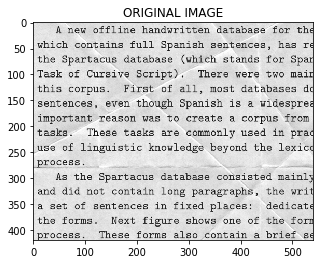

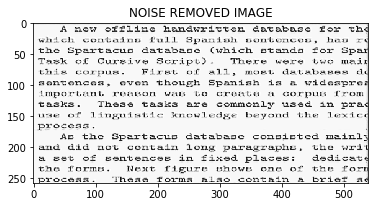


###################################################



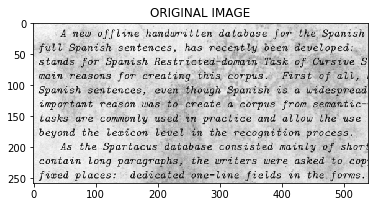

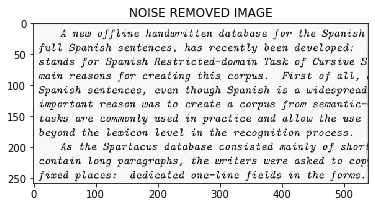


###################################################



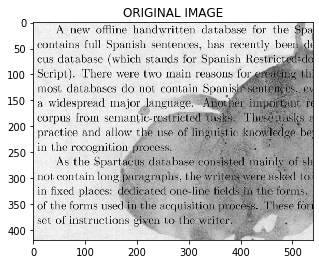

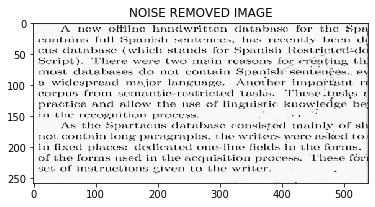


###################################################



In [ ]:
paths = glob.glob('/content/test/*.png')

for i in range(1,10):
  path = paths[i]
  single_image_prediction(path)